In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from inference.utils import normalize_phi, unnormalize_phi

In [3]:
model_id ='ContinuousSBM_FFResUNet_bottleneck_32_firstc_10_phi_beta_cosine_betamax_2.0_betamin_0.01'
input_dir ='/mnt/home/dheurtel/ceph/04_inference/sbc/'+model_id+'/'

In [4]:
## Matplotlib parameters
save_fig = True

params = {'text.usetex': True,
         'text.latex.preamble': r'\usepackage{amsmath}',
         "font.family": "serif", "font.serif": ["Computer Modern Roman"],
         'font.size': 12,
         'image.interpolation': 'none'}
plt.rcParams.update(params)

In [5]:
## Select high in f if you want only high noises, not high in f if you want only low noises and nothing if you want both
sbc_files = [f for f in os.listdir(input_dir) if ('sbcv2' in f )] #and 'high' not in f 
sbc_files.sort()
print(sbc_files)

counts = np.unique(np.array([int(f.split("_")[-1].split('.')[0]) for f in sbc_files]))
print("counts", counts)

['sbcv2_sims_SigmaMN_0.pt', 'sbcv2_sims_SigmaMN_1.pt', 'sbcv2_sims_SigmaMN_2.pt', 'sbcv2_sims_SigmaMN_3.pt', 'sbcv2_sims_SigmaMN_high_0.pt', 'sbcv2_sims_SigmaMN_high_1.pt', 'sbcv2_sims_SigmaMN_high_2.pt', 'sbcv2_sims_SigmaMN_high_3.pt']
counts [0 1 2 3]


In [6]:
max_num_samples = 180 ## Maximum number of samples to consider from SBC, adjust by increasing 
# so that all samples are counted (useful when analyzing sbc while it is running)

# Load files
phi_truth_all = None
phi_samples_all = None
sigma_truth_all = None
sigma_samples_all = None
for sbc_file in sbc_files:
    print(sbc_file)
    sbc_file = os.path.join(input_dir, sbc_file)
    sbc_data = torch.load(sbc_file)
    phi_truth = sbc_data["rphi_true"].detach().cpu()
    sigma_truth = sbc_data["sigma_true"].detach().cpu()
    phi_samples = sbc_data["tensor_rphi_list"].detach().cpu()
    sigma_samples = sbc_data["tensor_sigma_list"].detach().cpu()
    if phi_truth_all is None:
        if phi_samples.shape[0] < max_num_samples:
            continue
        phi_truth_all = phi_truth
        phi_samples_all = phi_samples[:max_num_samples, :, :]
        sigma_truth_all = sigma_truth
        sigma_samples_all = sigma_samples[:max_num_samples, :, :]
    else:
        if phi_samples.shape[0] < max_num_samples:
            continue
        phi_truth_all = torch.cat((phi_truth_all, phi_truth), dim=0)
        phi_samples_all = torch.cat((phi_samples_all, phi_samples[:max_num_samples, :, :]), dim=1)
        sigma_truth_all = torch.cat((sigma_truth_all, sigma_truth), dim=0)
        sigma_samples_all = torch.cat((sigma_samples_all, sigma_samples[:max_num_samples, :, :]), dim=1)
try:
    print(phi_truth_all.shape, phi_samples_all[:max_num_samples, :, :].shape, sigma_truth_all.shape, sigma_samples_all[:max_num_samples, :, :].shape)
except:
    print("No samples")

sbcv2_sims_SigmaMN_0.pt
sbcv2_sims_SigmaMN_1.pt
sbcv2_sims_SigmaMN_2.pt
sbcv2_sims_SigmaMN_3.pt
sbcv2_sims_SigmaMN_high_0.pt
sbcv2_sims_SigmaMN_high_1.pt
sbcv2_sims_SigmaMN_high_2.pt
sbcv2_sims_SigmaMN_high_3.pt
torch.Size([4096, 2]) torch.Size([180, 4096, 2]) torch.Size([4096, 1]) torch.Size([180, 4096, 1])


In [7]:
nb_burning_samples = 20

# Get rid of the burnin samples
phi_samples_all = phi_samples_all[nb_burning_samples:, :, :]
sigma_samples_all = sigma_samples_all[nb_burning_samples:, :, :]

In [8]:
sigma_samples_all.shape

torch.Size([160, 4096, 1])

In [9]:
N = sigma_samples_all.shape[1]//2
N

2048

In [10]:
## For each group of chains (2) compute ESS and Rhat and store them in a list. Use arviz

phi_ess = []
phi_rhat = []
sigma_ess = []
sigma_rhat = []

for i in range(N):
    ## Select chains 2i and 2i+1
    phi_samples = phi_samples_all[:, 2*i:2*i+2, :]
    sigma_samples = sigma_samples_all[:, 2*i:2*i+2, :]
    ## Move axis so that the first dimension is the number of chains (2)
    phi_samples = torch.moveaxis(phi_samples, 1, 0)
    sigma_samples = torch.moveaxis(sigma_samples, 1, 0)
    ## Put data to arviz format (concatenate phi and sigma)
    data = az.convert_to_inference_data({"phi": phi_samples, "sigma": sigma_samples})
    ## Compute ESS and Rhat
    ess = az.ess(data)
    rhat = az.rhat(data)
    ## Store them
    phi_ess.append(ess["phi"].values)
    phi_rhat.append(rhat["phi"].values)
    sigma_ess.append(ess["sigma"].values)
    sigma_rhat.append(rhat["sigma"].values)

/mnt/sw/nix/store/pvz51gzx2lyqpabf08xhd1y2kvw5rfdy-python-3.9.16-view/lib/python3.9/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [11]:
## Unormalize phi_truth_all 

phi_truth_all = unnormalize_phi(phi_truth_all)

In [13]:
phi_truth_all.max(), phi_truth_all.min()

(tensor(89.9656), tensor(0.0075))

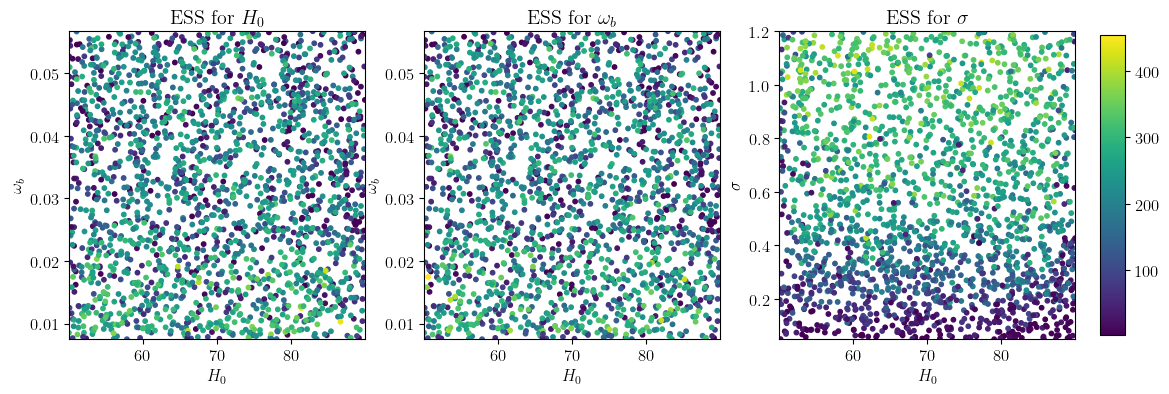

In [30]:
## Plot ESS as color for the targets

fig, ax = plt.subplots(1, 3, figsize=(12.5, 4),sharex=True)

phi_ess = np.array(phi_ess)
sigma_ess = np.array(sigma_ess)
num_samples_per_chain = phi_samples_all.shape[0]
num_samples_per_target = num_samples_per_chain * 2

phi_1_min = phi_truth_all[:, 0].min()
phi_1_max = phi_truth_all[:, 0].max()
phi_2_min = phi_truth_all[:, 1].min()
phi_2_max = phi_truth_all[:, 1].max()

ax[0].scatter(phi_truth_all[::2,0],phi_truth_all[::2,1], c=phi_ess[:, 0], cmap="viridis", s=10)
ax[0].set_xlabel("$H_0$")
ax[0].set_ylabel("$\omega_b$")
ax[0].set_title("ESS for $H_0$")
ax[0].set_xlim([phi_1_min, phi_1_max])
ax[0].set_ylim([phi_2_min, phi_2_max])

ax[1].scatter(phi_truth_all[::2,0],phi_truth_all[::2,1], c=phi_ess[:, 1], cmap="viridis", s=10)
ax[1].set_xlabel("$H_0$")
ax[1].set_ylabel("$\omega_b$")
ax[1].set_title("ESS for $\omega_b$")
ax[1].set_xlim([phi_1_min, phi_1_max])
ax[1].set_ylim([phi_2_min, phi_2_max])

ax[2].scatter(phi_truth_all[::2,0],sigma_truth_all[::2,0], c=sigma_ess[:, 0], cmap="viridis" , s=10)
ax[2].set_xlabel("$H_0$")
ax[2].set_ylabel("$\sigma$")
ax[2].set_title("ESS for $\sigma$")
ax[2].set_xlim([phi_1_min, phi_1_max])
ax[2].set_ylim([0.05, 1.2])

fig.subplots_adjust(right=0.93, wspace=0.2)
cbar_ax = fig.add_axes([0.95, 0.12, 0.02, 0.75])
fig.colorbar(ax[0].collections[0], cax=cbar_ax)

if save_fig:
    plt.savefig("./figures/sbc_ess_phi_sigma.pdf", dpi=300, bbox_inches="tight")

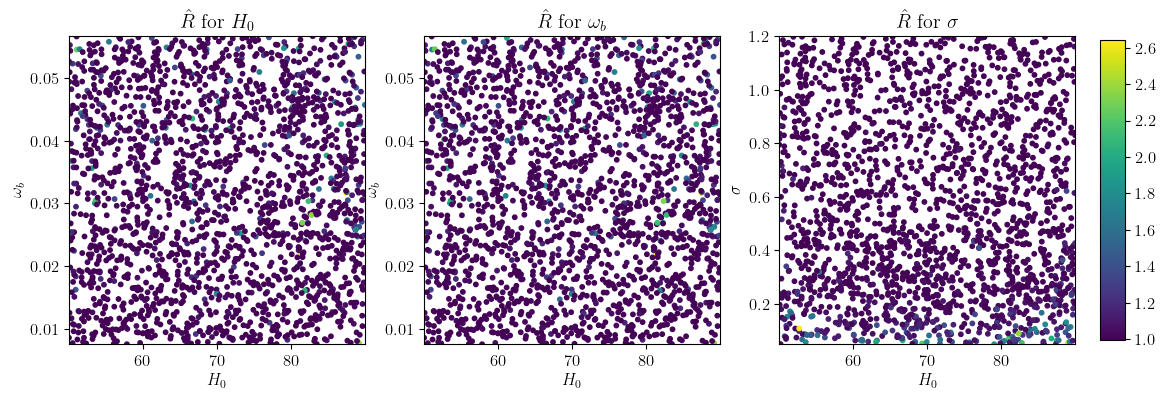

In [31]:
## Same for Rhat

fig, ax = plt.subplots(1, 3, figsize=(12.5, 4),sharex=True)

phi_rhat = np.array(phi_rhat)
sigma_rhat = np.array(sigma_rhat)

ax[0].scatter(phi_truth_all[::2,0],phi_truth_all[::2,1], c=phi_rhat[:, 0], cmap="viridis", s=10)
ax[0].set_xlabel("$H_0$")
ax[0].set_ylabel("$\omega_b$")
ax[0].set_title("$\hat{R}$ for $H_0$")
ax[0].set_xlim([phi_1_min, phi_1_max])
ax[0].set_ylim([phi_2_min, phi_2_max])

ax[1].scatter(phi_truth_all[::2,0],phi_truth_all[::2,1], c=phi_rhat[:, 1], cmap="viridis", s=10)
ax[1].set_xlabel("$H_0$")
ax[1].set_ylabel("$\omega_b$")
ax[1].set_title("$\hat{R}$ for $\omega_b$")
ax[1].set_xlim([phi_1_min, phi_1_max])
ax[1].set_ylim([phi_2_min, phi_2_max])

ax[2].scatter(phi_truth_all[::2,0],sigma_truth_all[::2,0], c=sigma_rhat[:, 0], cmap="viridis", s=10)
ax[2].set_xlabel("$H_0$")
ax[2].set_ylabel("$\sigma$")
ax[2].set_title("$\hat{R}$ for $\sigma$")
ax[2].set_xlim([phi_1_min, phi_1_max])
ax[2].set_ylim([0.05, 1.2])

fig.subplots_adjust(right=0.93, wspace=0.2)
cbar_ax = fig.add_axes([0.95, 0.12, 0.02, 0.75])
fig.colorbar(ax[0].collections[0], cax=cbar_ax)

(array([445., 250., 206., 203., 188., 229., 207., 226., 305., 350., 415.,
        413., 316., 187.,  91.,  40.,  14.,   6.,   2.,   3.]),
 array([  2.46073271,  25.01839244,  47.57605216,  70.13371188,
         92.6913716 , 115.24903133, 137.80669105, 160.36435077,
        182.9220105 , 205.47967022, 228.03732994, 250.59498966,
        273.15264939, 295.71030911, 318.26796883, 340.82562856,
        363.38328828, 385.940948  , 408.49860772, 431.05626745,
        453.61392717]),
 <BarContainer object of 20 artists>)

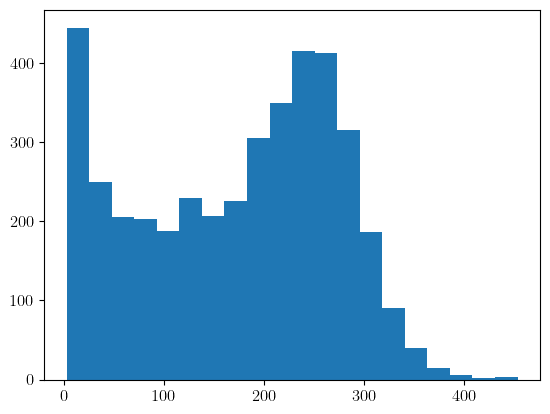

In [38]:
plt.hist(phi_ess.flatten(), bins=20)

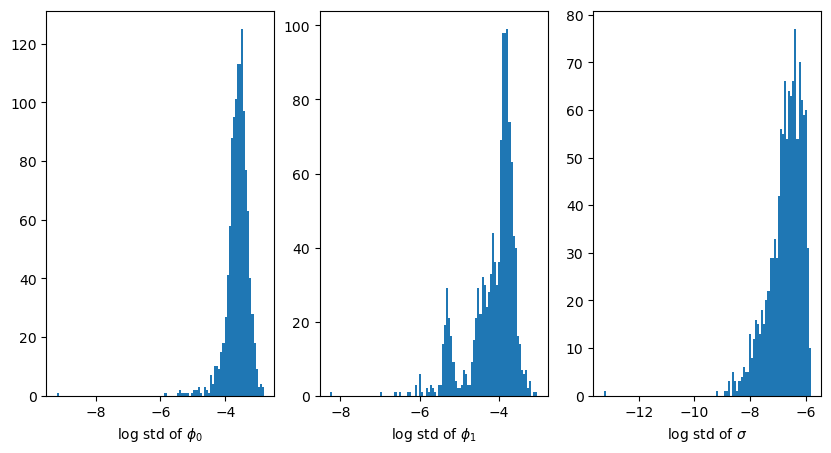

In [128]:
# Show histogram of stds
eps = 1e-9
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].hist(torch.log(phi_samples_all[..., 0].std(dim=0) + eps), bins=100)
axs[0].set_xlabel("log std of $\phi_0$")
axs[1].hist(torch.log(phi_samples_all[..., 1].std(dim=0) + eps), bins=100)
axs[1].set_xlabel("log std of $\phi_1$")
axs[2].hist(torch.log(sigma_samples_all[...,0].std(dim=0) + eps), bins=100)
axs[2].set_xlabel("log std of $\sigma$")
plt.show()

In [152]:
# Remove chains that have not converged (threshold on std of phi)
threshold = -6
converged_indices = torch.where(torch.logical_and(torch.log(phi_samples_all[..., 0].std(dim=0) + eps) >= threshold,
                                                torch.log(phi_samples_all[..., 1].std(dim=0) + eps) >= threshold))[0]
not_converged_indices = torch.where(torch.logical_or(torch.log(phi_samples_all[..., 0].std(dim=0) + eps) < threshold,
                                                    torch.log(phi_samples_all[..., 1].std(dim=0) + eps) < threshold))[0]
print("Number of chains that have not converged:", not_converged_indices.shape[0])

Number of chains that have not converged: 11


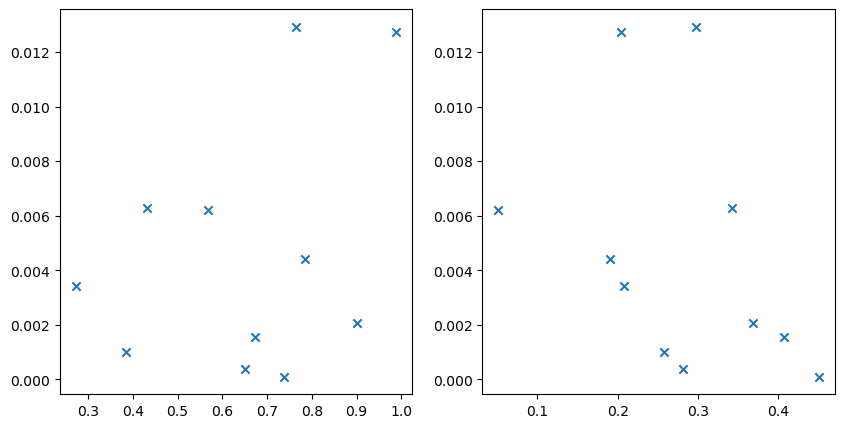

In [151]:
# Plot parameters for the chains that have not converged
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(phi_truth_all[not_converged_indices, 0],
            phi_truth_all[not_converged_indices, 1],
            marker='x')
ax[1].scatter(sigma_truth_all[not_converged_indices, 0],
            phi_truth_all[not_converged_indices, 1],
            marker='x')

In [142]:
remove_boundary = False
if remove_boundary:
    phi_min = torch.tensor([0.0, 0.0])
    phi_max = torch.tensor([1.0, 1.0])
    sigma_min = torch.tensor([0.05])
    sigma_max = torch.tensor([0.5])

    ## Remove all chains whose target is within 0.1 from the boundaries for phi or 0.05 for sigma

    within_phi_bounds = torch.logical_or(torch.logical_or(torch.logical_or(phi_truth_all[converged_indices, 0] <= phi_min[0] + 0.1,
                                                        phi_truth_all[converged_indices, 0] >= phi_max[0] - 0.1),
                                                        phi_truth_all[converged_indices, 1] <= phi_min[1] + 0.1),
                                                        phi_truth_all[converged_indices, 1] >= phi_max[1] - 0.1)
    within_sigma_bounds = torch.logical_or(sigma_truth_all[converged_indices, 0] <= sigma_min[0] + 0.05,
                                                        sigma_truth_all[converged_indices, 0] >= sigma_max[0] - 0.05)

    converged_indices = torch.where(torch.logical_not(torch.logical_or(within_phi_bounds, within_sigma_bounds)))[0]

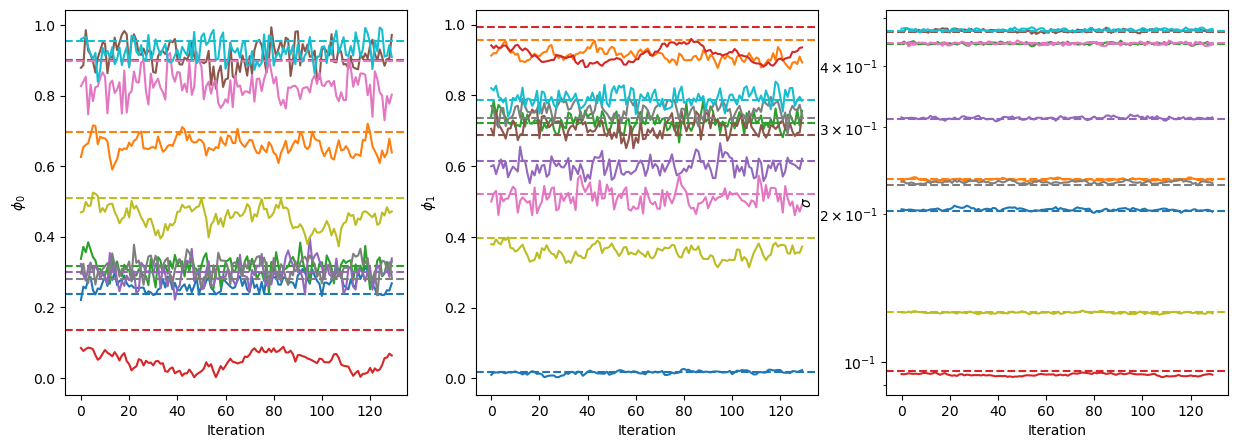

In [143]:
# Plot randomly selected chains
nb_plot_chains = 10

plot_indices = torch.randperm(phi_samples_all[:,converged_indices].shape[1])[:nb_plot_chains]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(nb_plot_chains):
    axs[0].plot(phi_samples_all[:,converged_indices][:, plot_indices[i], 0], color=f'C{i}')
    axs[0].axhline(phi_truth_all[converged_indices][plot_indices[i], 0], color=f'C{i}', linestyle='--')
    axs[1].plot(phi_samples_all[:,converged_indices][:, plot_indices[i], 1], color=f'C{i}')
    axs[1].axhline(phi_truth_all[converged_indices][plot_indices[i], 1], color=f'C{i}', linestyle='--')
    axs[2].plot(sigma_samples_all[:,converged_indices][:, plot_indices[i], 0], color=f'C{i}')
    axs[2].axhline(sigma_truth_all[converged_indices][plot_indices[i], 0], color=f'C{i}', linestyle='--')
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("$\phi_0$")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("$\phi_1$")
axs[2].set_xlabel("Iteration")
axs[2].set_ylabel("$\sigma$")
## Log scale for ax 3
axs[2].set_yscale('log')
plt.show()

In [144]:
# Compute rank statistics for phi
phi_truth_all_converged = phi_truth_all[converged_indices, :]
phi_samples_all_converged = phi_samples_all[:, converged_indices, :]
ranks = torch.zeros(phi_truth_all_converged.shape[0], phi_truth_all_converged.shape[1])
autocorrelation_length = torch.zeros(phi_truth_all_converged.shape[0], phi_truth_all_converged.shape[1])
for i in range(phi_truth_all_converged.shape[0]):
    az_infdata = az.convert_to_inference_data(phi_samples_all_converged[:, i][None, :].numpy())
    for j in range(phi_truth_all_converged.shape[1]):
        autocorrelation_length[i, j] = len(phi_samples_all_converged[:, i, j]) / az.ess(az_infdata)['x'].values[j]
        ranks[i, j] = torch.mean((phi_samples_all_converged[::max(int(autocorrelation_length[i, j]), 1), i, j] < phi_truth_all_converged[i, j]).float())

In [145]:
# Compute rank statistics for sigma
sigma_truth_all_converged = sigma_truth_all[converged_indices, :]
sigma_samples_all_converged = sigma_samples_all[:, converged_indices, :]
ranks_sigma = torch.zeros(sigma_truth_all_converged.shape[0])
autocorrelation_length_sigma = torch.zeros(sigma_truth_all_converged.shape[0])
for i in range(sigma_truth_all_converged.shape[0]):
    az_infdata = az.convert_to_inference_data(sigma_samples_all_converged[:, i][None, :].numpy())
    autocorrelation_length_sigma[i] = len(sigma_samples_all_converged[:, i]) / az.ess(az_infdata)['x'].values[0]
    ranks_sigma[i] = torch.mean((sigma_samples_all_converged[::max(int(autocorrelation_length_sigma[i]), 1), i] < sigma_truth_all_converged[i]).float())


In [146]:
from scipy.stats import binom

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


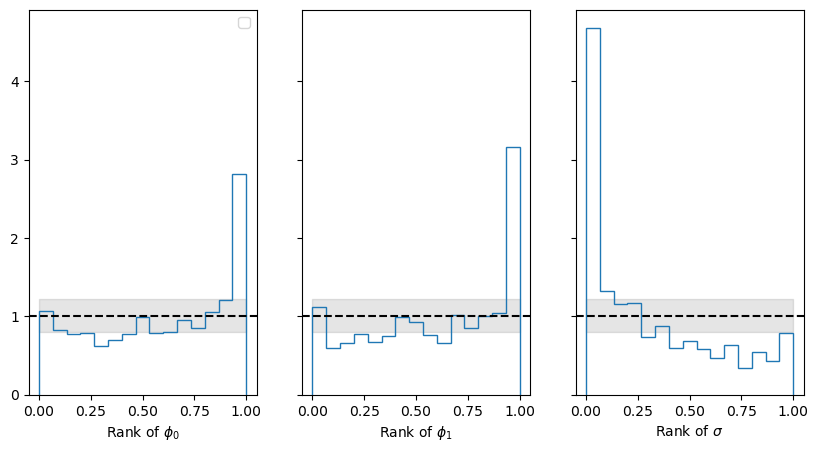

In [147]:
# Plot ranks statistics
fig, axs = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)
nbins = 15
axs[0].hist(ranks[:, 0], bins=nbins, density=True, histtype='step')
axs[1].hist(ranks[:, 1], bins=nbins, density=True, histtype='step')
axs[2].hist(ranks_sigma, bins=nbins, density=True, histtype='step')
N = ranks.shape[0]
q0 = binom.ppf(0.025, N, 1.0/nbins) * nbins/N
q1 = binom.ppf(0.975, N, 1.0/nbins) * nbins/N
axs[0].fill_between([0, 1], q0, q1, color='black', alpha=0.1) # 95% confidence interval (following Talts et al. 2018)
axs[1].fill_between([0, 1], q0, q1, color='black', alpha=0.1) # 95% confidence interval (following Talts et al. 2018)
axs[2].fill_between([0, 1], q0, q1, color='black', alpha=0.1) # 95% confidence interval (following Talts et al. 2018)
axs[0].axhline(1.0, color='black', linestyle='--')
axs[0].set_xlabel("Rank of $\phi_0$")
axs[1].axhline(1.0, color='black', linestyle='--')
axs[1].set_xlabel("Rank of $\phi_1$")
axs[2].axhline(1.0, color='black', linestyle='--')
axs[2].set_xlabel("Rank of $\sigma$")
axs[0].legend()
plt.show()

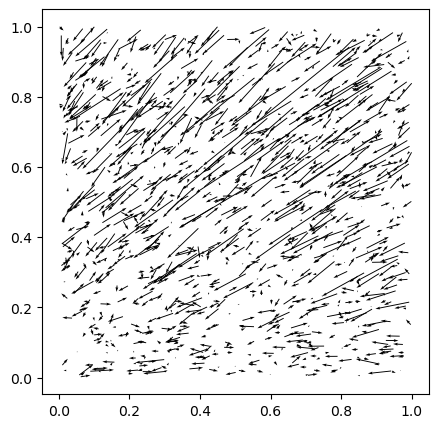

In [148]:
## Plot a vector field where each vector starts at the true value and ends at the mean of the chains
plt.figure(figsize=(5, 5))
plt.quiver(phi_truth_all_converged[:, 0], phi_truth_all_converged[:, 1], 
           phi_samples_all_converged.mean(dim=0)[:, 0] - phi_truth_all_converged[:, 0], 
           phi_samples_all_converged.mean(dim=0)[:, 1] - phi_truth_all_converged[:, 1], 
           scale=1, scale_units='xy', angles='xy')


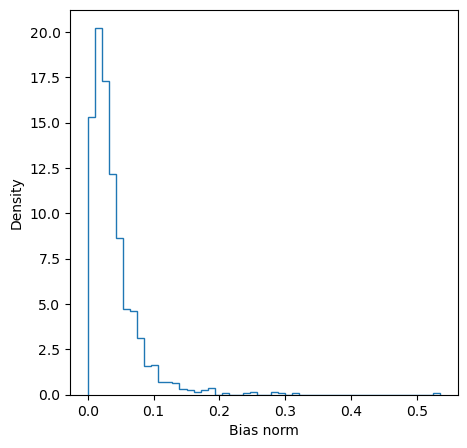

In [149]:
## Plot the distribution for the bias norm 

# Compute the bias norm
bias_norm = torch.norm(phi_samples_all_converged.mean(dim=0) - phi_truth_all_converged, dim=1)

# Plot the distribution
plt.figure(figsize=(5, 5))
plt.hist(bias_norm, bins=50, histtype='step', density=True)
plt.xlabel("Bias norm")
plt.ylabel("Density")
plt.show()